### 選擇比PCP履約價更價外2檔的

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import islice
from datetime import datetime, timedelta
import re
import os
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec
from matplotlib.font_manager import FontProperties as font
import matplotlib
matplotlib.rc('font', family='Microsoft JhengHei') # 在圖表上顯示中文
import matplotlib.ticker as mtick
from collections import Counter
import seaborn as sns

In [2]:
df_option_pcp = pd.read_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_new.csv', encoding = 'utf-8-sig')
df_tick = pd.read_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_tick.csv', encoding = 'utf-8-sig')
df_tick_1 = pd.read_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_tick_1.csv', encoding = 'utf-8-sig')
df_new_4 = df_option_pcp.copy()

前置設定：包含手續費、稅計畫、最終績效計算等等

In [2]:
def calculate_new_price(df_tick, df_new, strike_price_col):
    """
    根據 `df_tick` 尋找匹配的 `NewPrice`，並更新 `NewDate`、`NumMatchingTrades`
    
    參數：
    df_tick: 選擇權交易數據 DataFrame
    df_new: PCP 計算數據 DataFrame
    strike_price_col: 需要匹配的履約價欄位 (可傳 'StrikePrice', 'AtTheMoneyStrikePrice', 'SelectedStrikePrice')
    
    回傳：
    更新後的 df_new DataFrame
    """
    # **轉換 `df_tick` 的成交日期格式**
    df_tick["TradeDate"] = pd.to_datetime(df_tick["成交日期"].astype(str), format="%Y%m%d").dt.strftime("%Y-%m-%d")

    # **初始化新欄位**
    df_new["NewPrice"] = None
    df_new["NewDate"] = None
    df_new["NumMatchingTrades"] = 0

    # **遍歷 `df_new`**
    for idx, row in df_new.iterrows():
        original_date = row["Date"]
        strike_price = row[strike_price_col]  # **動態使用不同策略的履約價**
        category = row["Category"]
        product_code = row["ProductCode"]

        # **尋找符合條件的 `df_tick` 數據**
        matching_tick = df_tick[
            (df_tick["TradeDate"] == original_date) &
            (df_tick["履約價格"] == strike_price) &
            (df_tick["買賣權別"] == category) &
            (df_tick["到期月份(週別)"] == product_code)
        ]

        # **如果找到數據，直接更新 `NewDate`**
        if not matching_tick.empty:
            df_new.at[idx, "NewDate"] = original_date
        else:
            # **尋找下一個有效交易日**
            next_available_dates = sorted(df_tick["TradeDate"].unique())
            next_dates = [d for d in next_available_dates if d > original_date]
            next_date = next_dates[0] if next_dates else None

            # **如果找到新的交易日，更新篩選條件**
            if next_date:
                matching_tick = df_tick[
                    (df_tick["TradeDate"] == next_date) &
                    (df_tick["履約價格"] == strike_price) &
                    (df_tick["買賣權別"] == category) &
                    (df_tick["到期月份(週別)"] == product_code)
                ]
                df_new.at[idx, "NewDate"] = next_date
            else:
                df_new.at[idx, "NewDate"] = None

        # **計算平均價格 & 紀錄匹配交易筆數**
        if not matching_tick.empty:
            avg_price = matching_tick["成交價格"].mean()
            num_trades = matching_tick.shape[0]

            df_new.at[idx, "NewPrice"] = avg_price
            df_new.at[idx, "NumMatchingTrades"] = num_trades

    # **過濾掉 `NewPrice` 為 None 的數據**
    df_new = df_new.dropna(subset=["NewPrice"])

    # **回傳結果**
    return df_new


def calculate_fees_settlement(SettlementPrice):
    """計算稅與手續費"""
    tax = np.round(SettlementPrice * 0.00002 * 50,0)  # **稅**
    fee = np.round(10.8,0)  # **固定手續費**
    return tax + fee

def calculate_fees(price):
    """計算稅與手續費"""
    tax = np.round(price * 0.001 * 50,0)  # **稅**
    fee = np.round(10.8,0)  # **固定手續費**
    return tax + fee


def calculate_pnl(df_new, strike_price_col, price_col):
    """
    計算策略的損益，包括：
    1. 提前平倉 (`PnL_Early_Close`)
    2. 持有至到期 (`PnL_Settlement`)

    參數：
    df_new: PCP 計算數據 DataFrame
    strike_price_col: 履約價欄位 (可傳 'StrikePrice', 'AtTheMoneyStrikePrice', 'SelectedStrikePrice')

    回傳：
    更新後的 df_new DataFrame
    """
    # **計算內在價值**
    df_new["Intrinsic_Value"] = df_new.apply(
        lambda row: max(row["SettlementPrice"] - row[strike_price_col], 0) if row["Category"] == "C"
        else max(row[strike_price_col] - row["SettlementPrice"], 0), axis=1
    )

    # **計算第一種損益（買入 → 賣出）**
    df_new["PnL_Early_Close"] = (
        df_new["NewPrice"] * 50 - calculate_fees(df_new["NewPrice"])  # **賣出收入**
        - df_new[price_col] * 50 - calculate_fees(df_new[price_col])  # **買入成本**
    )

    # **計算第二種損益（持有至到期 → 結算）**
    df_new["PnL_Settlement"] = (
        df_new["Intrinsic_Value"] * 50 - calculate_fees_settlement(df_new["SettlementPrice"])  # **結算收入**
        - df_new[price_col] * 50 - calculate_fees(df_new[price_col])  # **買入成本**
    )

    # **回傳結果**
    return df_new


def calculate_strategy_performance(df, profit_column):
    """
    計算策略績效，包括：
    - 累積損益 (`Total PnL`)
    - 勝率 (`Win Rate`)
    - 賺賠比 (`Profit/Loss Ratio`)
    - 平均損益 (`Avg PnL`)
    
    參數：
    df: 交易數據 DataFrame
    profit_column: 要計算的損益欄位 (如 'PnL_Early_Close' 或 'PnL_Settlement')
    
    回傳：
    [累積損益, 勝率, 賺賠比, 平均損益]
    """
    total_pnl = df[profit_column].sum()
    win_rate = (df[df[profit_column] > 0].shape[0]) / df.shape[0]
    avg_profit = df[df[profit_column] > 0][profit_column].mean()
    avg_loss = abs(df[df[profit_column] < 0][profit_column].mean())
    profit_loss_ratio = avg_profit / avg_loss if avg_loss > 0 else float("inf")
    avg_pnl = total_pnl / df.shape[0]

    return [total_pnl, round(win_rate * 100, 2), round(profit_loss_ratio, 2), round(avg_pnl, 2)]


def calculate_cost(df, price_col):
    """計算累積成本（買入價格 * 合約單位 + 手續費）"""
    return (df[price_col] * 50 + calculate_fees(df[price_col])).sum()

def calculate_avg_cost(df, price_col):
    """計算平均成本（累積成本 / 總交易筆數）"""
    total_cost = calculate_cost(df, price_col)
    trade_count = len(df)
    return total_cost / trade_count if trade_count > 0 else 0

def calculate_total_profit(df, profit_col):
    """計算累積獲利金額（總收益，不扣除成本）"""
    return df[profit_col].sum()

def calculate_avg_profit(df, profit_col):
    """計算平均獲利（累積獲利 / 總交易筆數）"""
    total_profit = calculate_total_profit(df, profit_col)
    trade_count = len(df)
    return total_profit / trade_count if trade_count > 0 else 0


def generate_performance_table(df_list, strategy_names):
    """
    生成策略績效表格，包含：
    1️⃣ 累積損益
    2️⃣ 平均損益
    3️⃣ 累積獲利
    4️⃣ 平均獲利
    5️⃣ 累積成本
    6️⃣ 平均成本
    7️⃣ 勝率
    8️⃣ 賺賠比
    9️⃣ 每 1 元成本獲得獲利 (`Profit per Cost`)
    """
    performance_data = {
        "指標": ["累積損益", "平均損益", "累積獲利", "平均獲利", "累積成本", "平均成本", "勝率 (%)", "賺賠比", "每單位成本損益 (%)"]
    }

    for df, strategy in zip(df_list, strategy_names):
        # **提前平倉**
        cost_early = calculate_cost(df, "NewPrice")
        avg_cost_early = calculate_avg_cost(df, "NewPrice")
        total_profit_early = calculate_total_profit(df, "PnL_Early_Close")
        avg_profit_early = calculate_avg_profit(df, "PnL_Early_Close")
        profit_per_cost_early = (avg_profit_early/avg_cost_early) * 100
        pnl_early, win_rate_early, profit_loss_ratio_early, avg_pnl_early = calculate_strategy_performance(df, "PnL_Early_Close")

        # **持有至到期**
        cost_settle = calculate_cost(df, "SettlementPrice")
        avg_cost_settle = calculate_avg_cost(df, "SettlementPrice")
        total_profit_settle = calculate_total_profit(df, "PnL_Settlement")
        avg_profit_settle = calculate_avg_profit(df, "PnL_Settlement")
        profit_per_cost_settle = (avg_profit_settle/avg_cost_settle) * 100
        pnl_settle, win_rate_settle, profit_loss_ratio_settle, avg_pnl_settle = calculate_strategy_performance(df, "PnL_Settlement")

        performance_data[f"{strategy} - 提前平倉"] = [
            pnl_early, avg_pnl_early, total_profit_early + cost_early, avg_profit_early + avg_cost_early, cost_early, avg_cost_early, win_rate_early, profit_loss_ratio_early, profit_per_cost_early
        ]
        
        performance_data[f"{strategy} - 持有至到期"] = [
            pnl_settle, avg_pnl_settle, total_profit_settle + cost_settle, avg_profit_settle + avg_cost_settle, cost_settle, avg_cost_settle, win_rate_settle, profit_loss_ratio_settle, profit_per_cost_settle
        ]

    df_performance = pd.DataFrame(performance_data)

    return df_performance.style.set_properties(**{"text-align": "center"}).set_table_styles(
        [{"selector": "th", "props": [("text-align", "center")]}]
    ).format("{:,.2f}", subset=df_performance.columns[1:])



def generate_extreme_performance_summary(df_list, strategy_names):
    """
    計算 PnL_Early_Close 和 PnL_Settlement 的累積損益、平均損益、累積獲利、平均獲利、累積成本、平均成本、交易筆數，並加入每 1 元成本獲得的獲利
    """
    performance_data = {
        "指標": ["累積損益", "平均損益", "累積獲利", "平均獲利", "累積成本", "平均成本", "交易筆數", "每單位成本損益 (%)"]
    }

    for df, strategy in zip(df_list, strategy_names):
        # **提前平倉**
        cost_early = calculate_cost(df, "NewPrice")
        avg_cost_early = calculate_avg_cost(df, "NewPrice")
        total_profit_early = calculate_total_profit(df, "PnL_Early_Close")
        avg_profit_early = calculate_avg_profit(df, "PnL_Early_Close")
        profit_per_cost_early = (avg_profit_early/avg_cost_early) * 100
        pnl_early, _, _, avg_pnl_early = calculate_strategy_performance(df, "PnL_Early_Close")
        trade_count_early = len(df)

        # **持有至到期**
        cost_settle = calculate_cost(df, "SettlementPrice")
        avg_cost_settle = calculate_avg_cost(df, "SettlementPrice")
        total_profit_settle = calculate_total_profit(df, "PnL_Settlement")
        avg_profit_settle = calculate_avg_profit(df, "PnL_Settlement")
        profit_per_cost_settle = (avg_profit_settle/avg_cost_settle) * 100
        pnl_settle, _, _, avg_pnl_settle = calculate_strategy_performance(df, "PnL_Settlement")
        trade_count_settle = len(df)

        performance_data[f"{strategy} - 提前平倉"] = [
            pnl_early, avg_pnl_early, total_profit_early + cost_early, avg_profit_early + avg_cost_early, cost_early, avg_cost_early, trade_count_early, profit_per_cost_early
        ]
        
        performance_data[f"{strategy} - 持有至到期"] = [
            pnl_settle, avg_pnl_settle, total_profit_settle + cost_settle, avg_profit_settle + avg_cost_settle, cost_settle, avg_cost_settle, trade_count_settle, profit_per_cost_settle
        ]

    df_performance = pd.DataFrame(performance_data)

    return df_performance.style.set_properties(**{"text-align": "center"}).set_table_styles(
        [{"selector": "th", "props": [("text-align", "center")]}]
    ).format("{:,.2f}", subset=df_performance.columns[1:])

觀察StrikePrice，去市場上df_tick_1找相同ProductCode、Category，鄰近的Time (範圍設定5分鐘)
1. 如果Category為C，先捕捉鄰近Time中出現過的履約價，由大到小做排序，計算每個履約價在5分鐘內的成交均價，挑選其中成交價格價格最接近10的
2. 如果Category為P，先捕捉鄰近Time中出現過的履約價，由小到大做排序，計算每個履約價在5分鐘內的成交均價，挑選其中成交價格價格最接近10的
找到履約價之後，儲存為SelectedStrikePrice，然後那個5分鐘內的成交均價。儲存為SelectedPrice

In [5]:
import pandas as pd

def find_nearest_strike_price(df_tick, df_new):
    """根據市場履約價與成交均價，選擇鄰近履約價並計算成交均價"""
    
    # **確保 `成交時間` 為 int 格式**
    df_tick["成交時間"] = df_tick["成交時間"].astype(int)

    # **初始化新欄位**
    df_new["SelectedStrikePrice"], df_new["SelectedPrice"], df_new["Delta"], df_new["Vega"] = None, None, None, None

    for idx, row in df_new.iterrows():
        strike_price = row["StrikePrice"]
        product_code = row["ProductCode"]
        category = row["Category"]
        time = row["DateTime"]
        date = row["Date"]

        # **篩選符合條件的 Tick 數據**
        filtered_tick = df_tick[
            (df_tick["到期月份(週別)"] == product_code) &
            (df_tick["買賣權別"] == category) &
            (df_tick["TradeDate"] == date)
        ]

        # **篩選 5 分鐘內的成交數據**
        time_window = filtered_tick[
            (filtered_tick["成交時間"] >= time) & 
            (filtered_tick["成交時間"] <= time + 500)
        ]

        # **提取履約價格並排序**
        if category == "C":
            available_strikes = sorted(time_window["履約價格"].unique(), reverse=True)  # **Call：由大到小**
        else:
            available_strikes = sorted(time_window["履約價格"].unique())  # **Put：由小到大**

        # **計算每個履約價的成交均價**
        strike_avg_price = {
            s: time_window[time_window["履約價格"] == s]["成交價格"].mean()
            for s in available_strikes
        }

        # **選擇與 10 最接近的履約價**
        selected_strike = min(strike_avg_price, key=lambda x: abs(strike_avg_price[x] - 10)) if strike_avg_price else None

        # **存入選擇的履約價格 & 成交均價**
        if selected_strike:
            df_new.at[idx, "SelectedStrikePrice"] = selected_strike
            df_new.at[idx, "SelectedPrice"] = strike_avg_price[selected_strike]
            df_new.at[idx, "Delta"] = time_window[time_window["履約價格"] == selected_strike]["delta"].mean()
            df_new.at[idx, "Vega"] = time_window[time_window["履約價格"] == selected_strike]["vega"].mean()

    return df_new

# **執行函數**
df_new_processed = find_nearest_strike_price(df_tick_1, df_new_4)

# **檢查結果**
print(df_new_processed.head())
print(f"✅ 更新後數據量: {len(df_new_processed)}")

                  Time Category  Price          ID   Fee  StrikePrice  \
0  2024-02-01 04:05:00        C    7.0  TX118600B4  11.0      18600.0   
1  2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
2  2024-02-01 04:10:00        C   14.5  TX118450B4  12.0      18450.0   
3  2024-02-23 04:52:00        P    6.4  TX418500N4  11.0      18500.0   
4  2024-03-09 04:46:00        P    3.3  TX218850O4  11.0      18850.0   

   FutPrice        Date ProductCode  SettlementPrice SettlementDate  DateTime  \
0   17917.0  2024-02-01    202402W1            18632     2024-02-15     40500   
1   17910.0  2024-02-01    202402W1            18632     2024-02-15     41000   
2   17913.0  2024-02-01    202402W1            18632     2024-02-15     41000   
3   18994.0  2024-02-23    202402W4            18993     2024-02-29     45200   
4   19744.0  2024-03-09    202403W2            19931     2024-03-13     44600   

  SelectedStrikePrice SelectedPrice     Delta      Vega  
0             18

In [6]:
df_new_processed

,Time,Category,Price,ID,Fee,StrikePrice,FutPrice,Date,ProductCode,SettlementPrice,SettlementDate,DateTime,SelectedStrikePrice,SelectedPrice,Delta,Vega
0,2024-02-01 04:05:00,C,7.0,TX118600B4,11.0,18600.0,17917.0,2024-02-01,202402W1,18632,2024-02-15,40500,18500.0,10.8125,0.067577,4.641709
1,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17910.0,2024-02-01,202402W1,18632,2024-02-15,41000,18550.0,8.0,0.053392,3.863429
2,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17913.0,2024-02-01,202402W1,18632,2024-02-15,41000,18550.0,8.0,0.053392,3.863429
3,2024-02-23 04:52:00,P,6.4,TX418500N4,11.0,18500.0,18994.0,2024-02-23,202402W4,18993,2024-02-29,45200,18600.0,10.648936,-0.078201,3.666316
4,2024-03-09 04:46:00,P,3.3,TX218850O4,11.0,18850.0,19744.0,2024-03-09,202403W2,19931,2024-03-13,44600,19100.0,11.0,-0.059194,2.54624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,2025-04-03 04:48:00,C,51.0,TX221450D5,14.0,21450.0,20884.0,2025-04-03,202504W2,17430,2025-04-09,44800,22150.0,10.0,0.038145,2.288812
590,2025-04-03 04:48:00,C,33.0,TX221450D5,13.0,21450.0,20868.0,2025-04-03,202504W2,17430,2025-04-09,44800,22150.0,10.0,0.038145,2.288812
591,2025-04-03 04:49:00,C,62.0,TX221600D5,14.0,21600.0,20827.0,2025-04-03,202504W2,17430,2025-04-09,44900,22150.0,10.0,0.038145,2.288812
592,2025-04-18 04:15:00,C,92.0,TX419900D5,16.0,19900.0,19322.0,2025-04-18,202504W4,19583,2025-04-23,41500,20700.0,8.9,0.032855,1.723301


In [7]:
df_new_4 = calculate_new_price(df_tick, df_new_processed, "SelectedStrikePrice")  # **策略 3**
df_new_4 = calculate_pnl(df_new_4, "SelectedStrikePrice", "SelectedPrice")

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_16456\418958008.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["Intrinsic_Value"] = df_new.apply(
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_16456\418958008.py:105: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new["PnL_Early_Close"] = (
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_16456\418958008.py:111: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer

整體觀察

In [3]:
df_new_4 = pd.read_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_strategy_4.csv', encoding = 'utf-8-sig')

#### 設定
1. df_list 整體數據 - df_new_4
2. df_list_4 去除4/3之數據 - df_clean
3. df_list_43 4/3之數據 - df_fliter
4. df_list_o 分為c, p之數據 - df_new_4_call, df_new_4_put
5. df_list_o_4 去除4/3之c, p數據 - df_clean_4_call, df_clean_4_put
6. df_list_o_43 4/3之c, p數據 - df_fliter_call, df_fliter_put


In [4]:
# **測試函數**
strategy_names = ["策略 4"]
df_list = [df_new_4]

df_performance_styled = generate_performance_table(df_list, strategy_names)

from IPython.display import display
print("📌 策略績效表格（包含所有策略）：")
display(df_performance_styled)  # **顯示格式化表格**

📌 策略績效表格（包含所有策略）：


,指標,策略 4 - 提前平倉,策略 4 - 持有至到期
0,累積損益,"302,458.67","428,546.20"
1,平均損益,510.91,723.90
2,累積獲利,"932,109.68","638,339,021.20"
3,平均獲利,"1,574.51","1,078,275.37"
4,累積成本,"629,651.01","637,910,475.00"
5,平均成本,"1,063.60","1,077,551.48"
6,勝率 (%),38.51,10.14
7,賺賠比,6.77,21.55
8,每單位成本損益 (%),48.04,0.07


In [5]:
df_fliter = df_new_4[df_new_4["Date"] == "2025-04-03"]
df_clean = df_new_4[df_new_4["Date"] != "2025-04-03"]
df_list_4 = [df_clean]
df_list_43 = [df_fliter]

In [6]:
df_performance_styled = generate_performance_table(df_list_4, strategy_names)
df_extreme_summary = generate_extreme_performance_summary(df_list_43, strategy_names)

from IPython.display import display
print("📌 策略績效表格（去除極端值後）：") 
display(df_performance_styled)

print("📌 極端數據表：")
display(df_extreme_summary)

📌 策略績效表格（去除極端值後）：


,指標,策略 4 - 提前平倉,策略 4 - 持有至到期
0,累積損益,681.97,"-53,100.50"
1,平均損益,1.37,-106.63
2,累積獲利,"279,077.10","555,853,372.50"
3,平均獲利,560.40,"1,116,171.43"
4,累積成本,"278,395.13","555,906,473.00"
5,平均成本,559.03,"1,116,278.06"
6,勝率 (%),44.58,10.84
7,賺賠比,1.26,6.50
8,每單位成本損益 (%),0.24,-0.01


📌 極端數據表：


,指標,策略 4 - 提前平倉,策略 4 - 持有至到期
0,累積損益,"301,776.70","481,646.70"
1,平均損益,"3,210.39","5,123.90"
2,累積獲利,"653,032.58","82,485,648.70"
3,平均獲利,"6,947.16","877,506.90"
4,累積成本,"351,255.88","82,004,002.00"
5,平均成本,"3,736.76","872,383.00"
6,交易筆數,94.00,94.00
7,每單位成本損益 (%),85.91,0.59


Call, Put個別觀察

In [7]:
df_new_4_call = df_new_4[df_new_4["Category"] == "C"]
df_new_4_put = df_new_4[df_new_4["Category"] == "P"]
df_list_o = [df_new_4_call, df_new_4_put]
strategy_names_o = ["策略4 - Call", "策略4 - Put"]

df_performance_styled_4 = generate_performance_table(df_list_o, strategy_names_o)

from IPython.display import display
print("📌 策略績效表格（包含所有策略）：")
display(df_performance_styled_4)  # **顯示格式化表格**

📌 策略績效表格（包含所有策略）：


,指標,策略4 - Call - 提前平倉,策略4 - Call - 持有至到期,策略4 - Put - 提前平倉,策略4 - Put - 持有至到期
0,累積損益,"-45,257.76","-29,021.39","347,716.43","457,567.59"
1,平均損益,-96.91,-62.14,"2,781.73","3,660.54"
2,累積獲利,"163,801.62","498,169,719.61","768,308.06","140,169,301.59"
3,平均獲利,350.75,"1,066,744.58","6,146.46","1,121,354.41"
4,累積成本,"209,059.38","498,198,741.00","420,591.63","139,711,734.00"
5,平均成本,447.66,"1,066,806.73","3,364.73","1,117,693.87"
6,勝率 (%),38.33,11.56,39.20,4.80
7,賺賠比,0.78,6.68,93.08,148.90
8,每單位成本損益 (%),-21.65,-0.01,82.67,0.33


In [8]:
df_fliter_call = df_new_4_call[df_new_4_call["Date"] == "2025-04-03"]
df_fliter_put = df_new_4_put[df_new_4_put["Date"] == "2025-04-03"]

df_clean_4_call = df_new_4_call[df_new_4_call["Date"] != "2025-04-03"]
df_clean_4_put = df_new_4_put[df_new_4_put["Date"] != "2025-04-03"]

df_list_o_4 = [df_clean_4_call, df_clean_4_put]
df_list_o_43 = [df_fliter_call, df_fliter_put]

df_performance_styled_4 = generate_performance_table(df_list_o_4, strategy_names_o)
df_extreme_summary_4 = generate_extreme_performance_summary(df_list_o_43, strategy_names_o)

from IPython.display import display
print("📌 策略績效表格（去除極端值後）：") 
display(df_performance_styled_4)

print("📌 極端數據表：")
display(df_extreme_summary_4)


📌 策略績效表格（去除極端值後）：


,指標,策略4 - Call - 提前平倉,策略4 - Call - 持有至到期,策略4 - Put - 提前平倉,策略4 - Put - 持有至到期
0,累積損益,"-8,656.03","17,214.95","9,338.00","-70,315.45"
1,平均損益,-22.84,45.42,78.47,-590.89
2,累積獲利,"191,288.60","421,446,251.95","87,788.50","134,407,120.55"
3,平均獲利,504.72,"1,111,995.39",737.72,"1,129,471.60"
4,累積成本,"199,944.63","421,429,037.00","78,450.50","134,477,436.00"
5,平均成本,527.56,"1,111,949.97",659.25,"1,130,062.49"
6,勝率 (%),47.23,14.25,36.13,0.00
7,賺賠比,0.93,6.58,4.57,nan
8,每單位成本損益 (%),-4.33,0.00,11.90,-0.05


📌 極端數據表：


,指標,策略4 - Call - 提前平倉,策略4 - Call - 持有至到期,策略4 - Put - 提前平倉,策略4 - Put - 持有至到期
0,累積損益,"-36,601.73","-46,236.34","338,378.43","527,883.04"
1,平均損益,-415.93,-525.41,"56,396.41","87,980.51"
2,累積獲利,"-27,486.98","76,723,467.66","680,519.56","5,762,181.04"
3,平均獲利,-312.35,"871,857.59","113,419.93","960,363.51"
4,累積成本,"9,114.75","76,769,704.00","342,141.13","5,234,298.00"
5,平均成本,103.58,"872,383.00","57,023.52","872,383.00"
6,交易筆數,88.00,88.00,6.00,6.00
7,每單位成本損益 (%),-401.57,-0.06,98.90,10.09


In [29]:
df_new_4.to_csv(r'D:\CODE\SC_SP_delay_weekly策略\data\df_strategy_4.csv',index = False, encoding = 'utf-8-sig')
df_new_4

,Time,Category,Price,ID,Fee,StrikePrice,FutPrice,Date,ProductCode,SettlementPrice,...,SelectedStrikePrice,SelectedPrice,Delta,Vega,NewPrice,NewDate,NumMatchingTrades,Intrinsic_Value,PnL_Early_Close,PnL_Settlement
0,2024-02-01 04:05:00,C,7.0,TX118600B4,11.0,18600.0,17917.0,2024-02-01,202402W1,18632,...,18500.0,10.8125,0.067577,4.641709,12.533775,2024-02-01,151,132.0,62.896428,6017.834375
1,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17910.0,2024-02-01,202402W1,18632,...,18550.0,8.0,0.053392,3.863429,9.016667,2024-02-01,24,82.0,27.9825,3658.6
2,2024-02-01 04:10:00,C,14.5,TX118450B4,12.0,18450.0,17913.0,2024-02-01,202402W1,18632,...,18550.0,8.0,0.053392,3.863429,9.016667,2024-02-01,24,82.0,27.9825,3658.6
3,2024-02-23 04:52:00,P,6.4,TX418500N4,11.0,18500.0,18994.0,2024-02-23,202402W4,18993,...,18600.0,10.648936,-0.078201,3.666316,11.255344,2024-02-23,421,0.0,7.225198,-573.979255
4,2024-03-09 04:46:00,P,3.3,TX218850O4,11.0,18850.0,19744.0,2024-03-09,202403W2,19931,...,19100.0,11.0,-0.059194,2.54624,9.682432,2024-03-11,148,0.0,-88.9125,-592.55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,2025-04-03 04:48:00,C,51.0,TX221450D5,14.0,21450.0,20884.0,2025-04-03,202504W2,17430,...,22150.0,10.0,0.038145,2.288812,6.1,2025-04-07,154,0.0,-217.805,-539.5
590,2025-04-03 04:48:00,C,33.0,TX221450D5,13.0,21450.0,20868.0,2025-04-03,202504W2,17430,...,22150.0,10.0,0.038145,2.288812,6.1,2025-04-07,154,0.0,-217.805,-539.5
591,2025-04-03 04:49:00,C,62.0,TX221600D5,14.0,21600.0,20827.0,2025-04-03,202504W2,17430,...,22150.0,10.0,0.038145,2.288812,6.1,2025-04-07,154,0.0,-217.805,-539.5
592,2025-04-18 04:15:00,C,92.0,TX419900D5,16.0,19900.0,19322.0,2025-04-18,202504W4,19583,...,20700.0,8.9,0.032855,1.723301,7.177778,2025-04-18,36,0.0,-108.915,-487.445


想要看整體報酬的分布狀況 (使用PnL_Early_Close, PnL_Settlement)

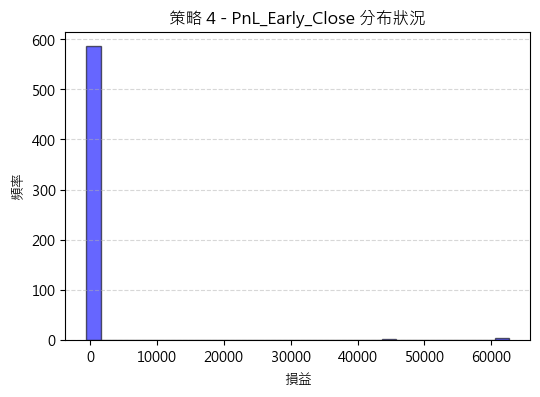

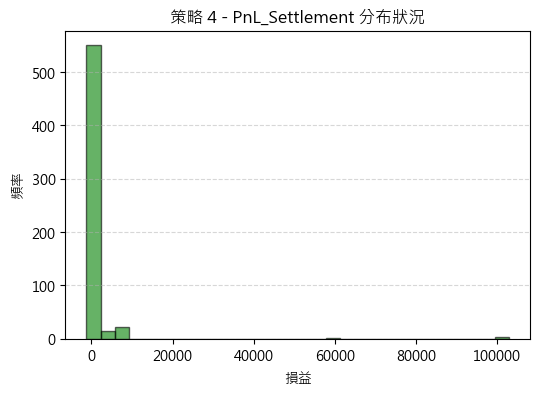

In [90]:
def plot_pnl_distribution(df_list, strategy_names):
    """分別繪製 PnL_Early_Close 和 PnL_Settlement 的直方圖"""
    
    for df, strategy in zip(df_list, strategy_names):
        # **PnL_Early_Close 直方圖**
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.hist(df["PnL_Early_Close"], bins=30, alpha=0.6, color="blue", edgecolor="black")
        ax.set_title(f"{strategy} - PnL_Early_Close 分布狀況", fontsize=12)
        ax.set_xlabel("損益", fontsize=10)
        ax.set_ylabel("頻率", fontsize=10)
        ax.grid(axis="y", linestyle="--", alpha=0.5)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))  # 確保負數正常顯示
        plt.show()

        # **PnL_Settlement 直方圖**
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.hist(df["PnL_Settlement"], bins=30, alpha=0.6, color="green", edgecolor="black")
        ax.set_title(f"{strategy} - PnL_Settlement 分布狀況", fontsize=12)
        ax.set_xlabel("損益", fontsize=10)
        ax.set_ylabel("頻率", fontsize=10)
        ax.grid(axis="y", linestyle="--", alpha=0.5)
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))  # 確保負數正常顯示
        plt.show()

plot_pnl_distribution(df_list, strategy_names)

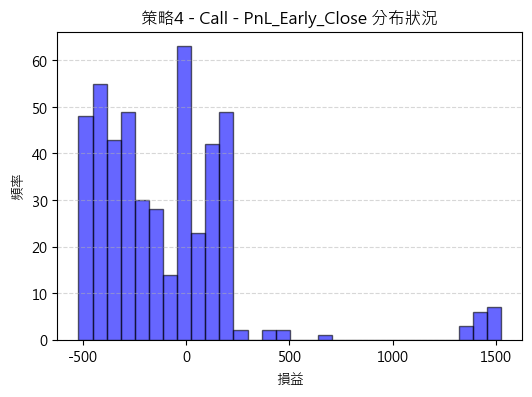

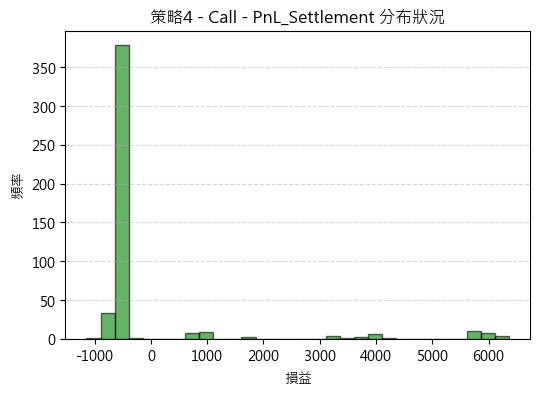

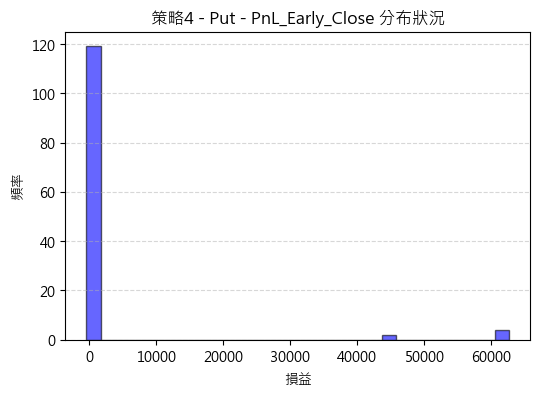

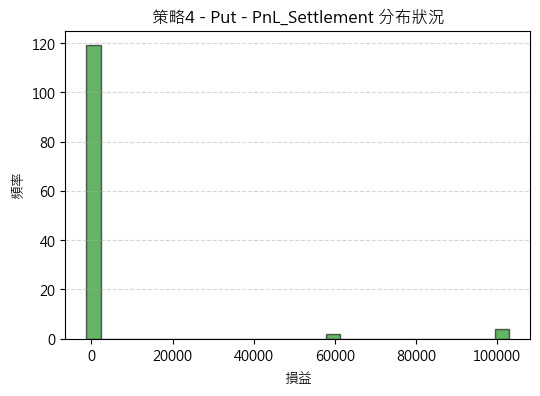

In [91]:
plot_pnl_distribution(df_list_o, strategy_names_o)

去除極端值後做觀察

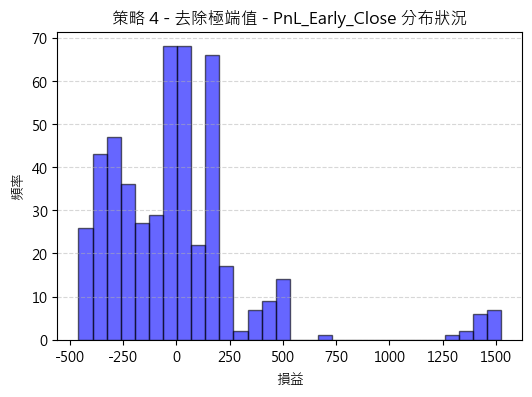

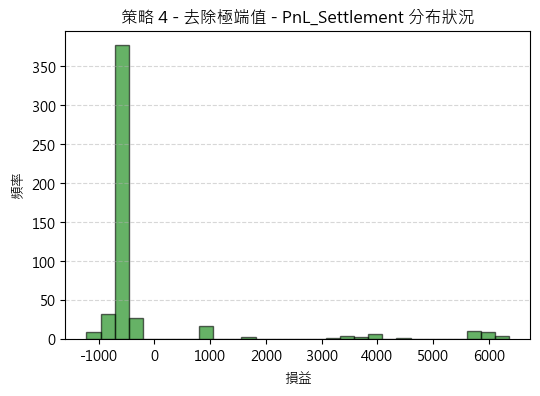

In [93]:
strategy_names_4 = ["策略 4 - 去除極端值"]
plot_pnl_distribution(df_list_4, strategy_names_4)

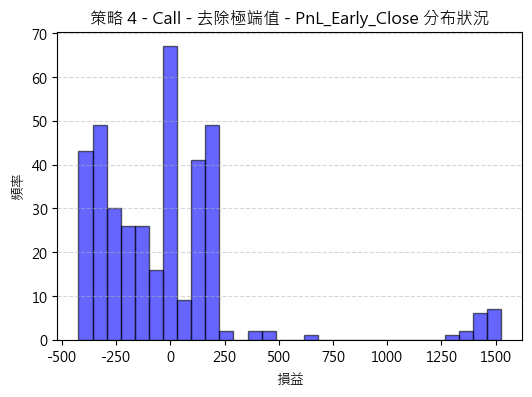

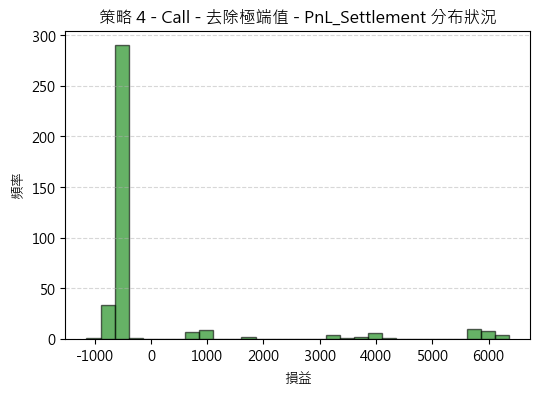

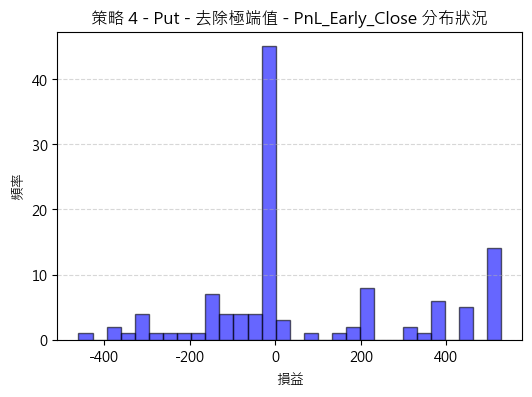

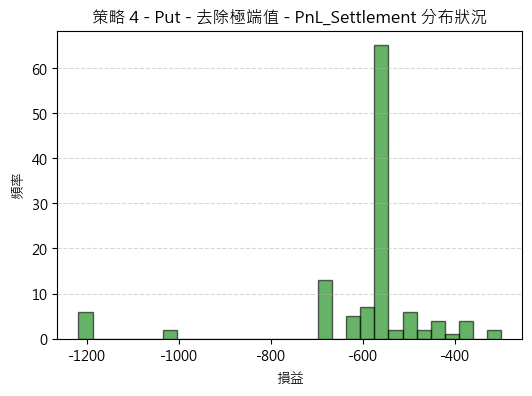

In [96]:
strategy_names_o_4 = ["策略 4 - Call - 去除極端值", "策略 4 - Put - 去除極端值"]
plot_pnl_distribution(df_list_o_4, strategy_names_o_4)

#### 逐日績效累積觀察

隔日平倉

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


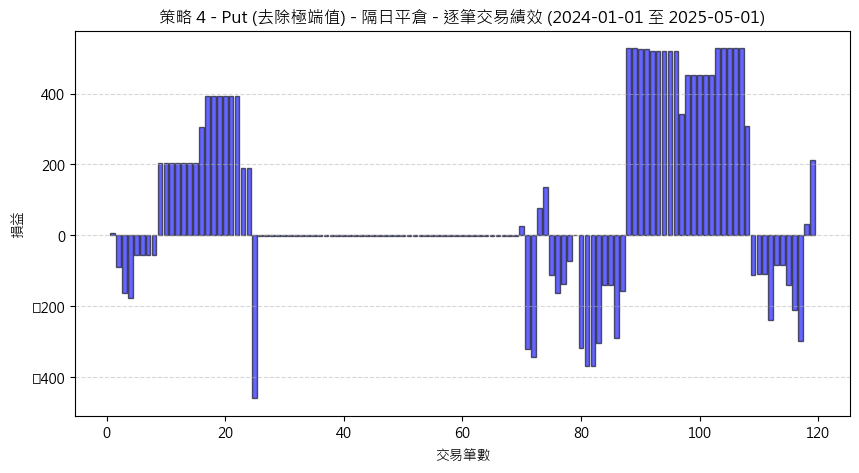

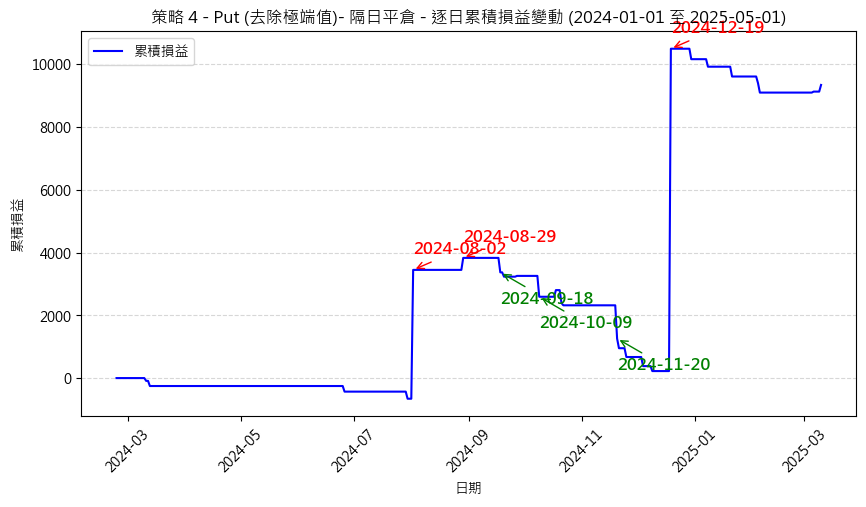

In [110]:
def format_date_range(start_date, end_date):
    """格式化時間範圍為 YYYY-MM-DD"""
    return f"{start_date.strftime('%Y-%m-%d')} 至 {end_date.strftime('%Y-%m-%d')}" if start_date and end_date else ""

def plot_trade_performance(df, strategy_name, start_date=None, end_date=None):
    """繪製逐筆績效表現（長條圖），可選擇時間範圍"""
    
    df = df.copy()
    df.loc[:, "NewDate"] = pd.to_datetime(df["NewDate"])  # **確保日期格式正確**
    
    # **篩選時間範圍**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["NewDate"] >= start_date) & (df["NewDate"] <= end_date)]
    
    df["Trade_Index"] = range(1, len(df) + 1)  # **為每筆交易建立索引**
    
    plt.figure(figsize=(10, 5))
    plt.bar(df["Trade_Index"], df["PnL_Early_Close"], color="blue", alpha=0.6, edgecolor="black")
    date_range_str = format_date_range(start_date, end_date)
    plt.title(f"{strategy_name} - 隔日平倉 - 逐筆交易績效 ({date_range_str})")
    plt.xlabel("交易筆數")
    plt.ylabel("損益")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

def plot_daily_cumulative_pnl(df, strategy_name, start_date=None, end_date=None):
    """繪製逐日累積損益走勢，可選擇時間範圍"""
    
    df = df.copy()
    df.loc[:, "NewDate"] = pd.to_datetime(df["NewDate"])  # **確保日期為 datetime**
    
    # **篩選時間範圍**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["NewDate"] >= start_date) & (df["NewDate"] <= end_date)]
    
    # **將同一天的數據加總**
    df_daily = df.groupby("NewDate", as_index=False)["PnL_Early_Close"].sum()
    
    # **填補缺失日期（視為損益持平）**
    full_dates = pd.date_range(start=df_daily["NewDate"].min(), end=df_daily["NewDate"].max(), freq="D")
    df_daily = df_daily.set_index("NewDate").reindex(full_dates, fill_value=0).reset_index()
    df_daily.rename(columns={"index": "NewDate"}, inplace=True)
    
    # **計算累積損益**
    df_daily["Cumulative_PnL"] = df_daily["PnL_Early_Close"].cumsum()

    # **識別異常變動點**
    df_daily["PnL_Change"] = df_daily["Cumulative_PnL"].diff()
    # **確保 'PnL_Change' 欄位是 float 型態**
    df_daily["PnL_Change"] = pd.to_numeric(df_daily["PnL_Change"], errors="coerce")

    # **去除 NaN 值**
    df_daily = df_daily.dropna(subset=["PnL_Change"])
    highlight_dates_1 = df_daily.nlargest(3, "PnL_Change")["NewDate"]  # **找出變動最大的3天**
    highlight_dates_2 = df_daily.nsmallest(3, "PnL_Change")["NewDate"]  # **找出變動最小的3天**

    # **繪製累積損益折線圖**
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_daily["NewDate"], df_daily["Cumulative_PnL"], color="blue", linestyle="-", label="累積損益")

    # **標註異常波動點（向上移動，標註文字改為紅色）**
    for date in highlight_dates_1:
        pnl_value = df_daily.loc[df_daily["NewDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value + 500),  # **向上調整標註位置**
                    arrowprops=dict(arrowstyle="->", color="red"),
                    color="red", fontsize=12, fontweight="bold")  # **標註日期為紅色**
    
    for date in highlight_dates_2:
        pnl_value = df_daily.loc[df_daily["NewDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value - 1000),  # **向上調整標註位置**
                    arrowprops=dict(arrowstyle="->", color="green"),
                    color="green", fontsize=12, fontweight="bold")  # **標註日期為紅色**


    date_range_str = format_date_range(start_date, end_date)
    ax.set_title(f"{strategy_name}- 隔日平倉 - 逐日累積損益變動 ({date_range_str})")
    ax.set_xlabel("日期")
    ax.set_ylabel("累積損益")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.show()


# df_new_4
# df_clean
# df_fliter
# df_new_4_call, df_new_4_put
# df_clean_4_call, df_clean_4_put
# df_fliter_call, df_fliter_put


plot_trade_performance(df_clean_4_put, "策略 4 - Put (去除極端值)", start_date="2024-01-01", end_date="2025-05-01")
plot_daily_cumulative_pnl(df_clean_4_put, "策略 4 - Put (去除極端值)", start_date="2024-01-01", end_date="2025-05-01")

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


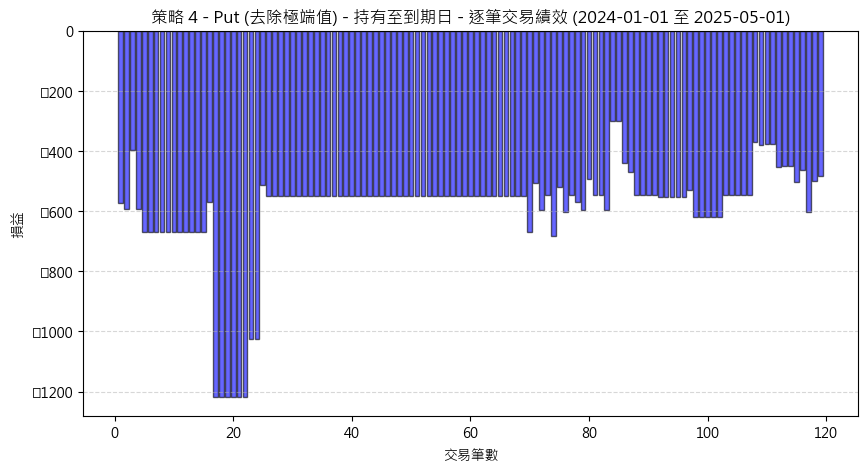

c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


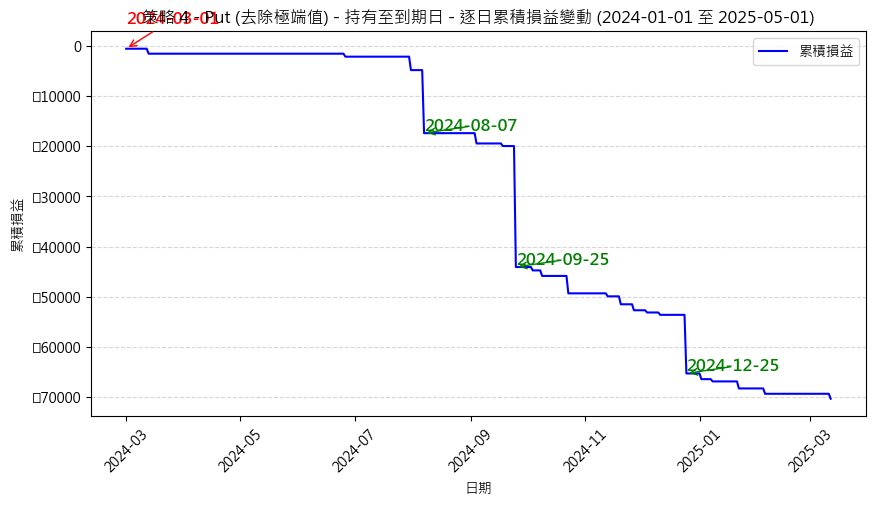

In [112]:
def format_date_range(start_date, end_date):
    """格式化時間範圍為 YYYY-MM-DD"""
    return f"{start_date.strftime('%Y-%m-%d')} 至 {end_date.strftime('%Y-%m-%d')}" if start_date and end_date else ""

def plot_trade_performance_settlement(df, strategy_name, start_date=None, end_date=None):
    """繪製逐筆交易績效（長條圖），標題顯示簡化時間格式"""
    
    df = df.copy()
    df.loc[:, "SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **確保日期格式正確**
    
    # **篩選時間範圍**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["SettlementDate"] >= start_date) & (df["SettlementDate"] <= end_date)]
    
    df["Trade_Index"] = range(1, len(df) + 1)  # **為每筆交易建立索引**
    
    plt.figure(figsize=(10, 5))
    plt.bar(df["Trade_Index"], df["PnL_Settlement"], color="blue", alpha=0.6, edgecolor="black")
    
    # **簡化時間範圍**
    date_range_str = format_date_range(start_date, end_date)
    plt.title(f"{strategy_name} - 持有至到期日 - 逐筆交易績效 ({date_range_str})")
    
    plt.xlabel("交易筆數")
    plt.ylabel("損益")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.show()

def plot_daily_cumulative_pnl_settlement(df, strategy_name, start_date=None, end_date=None):
    """繪製逐日累積損益走勢，標題顯示簡化時間格式"""
    
    df = df.copy()
    df.loc[:, "SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **確保日期格式正確**

    # **篩選時間範圍**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df = df[(df["SettlementDate"] >= start_date) & (df["SettlementDate"] <= end_date)]
    
    # **將同一天的數據加總**
    df_daily = df.groupby("SettlementDate", as_index=False)["PnL_Settlement"].sum()

    # **填補缺失日期（視為損益持平）**
    full_dates = pd.date_range(start=df_daily["SettlementDate"].min(), end=df_daily["SettlementDate"].max(), freq="D")
    df_daily = df_daily.set_index("SettlementDate").reindex(full_dates, fill_value=0).reset_index()
    df_daily.rename(columns={"index": "SettlementDate"}, inplace=True)

    # **計算累積損益**
    df_daily["Cumulative_PnL"] = df_daily["PnL_Settlement"].cumsum()

    # **識別異常變動點**
    df_daily["PnL_Change"] = df_daily["Cumulative_PnL"].diff()
    # **確保 'PnL_Change' 欄位是 float 型態**
    df_daily["PnL_Change"] = pd.to_numeric(df_daily["PnL_Change"], errors="coerce")

    # **去除 NaN 值**
    df_daily = df_daily.dropna(subset=["PnL_Change"])
    highlight_dates_1 = df_daily.nlargest(1, "PnL_Change")["SettlementDate"]  # **找出變動最大的3天**
    highlight_dates_2 = df_daily.nsmallest(3, "PnL_Change")["SettlementDate"]  # **找出變動最大的3天**

    # **繪製累積損益折線圖**
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_daily["SettlementDate"], df_daily["Cumulative_PnL"], color="blue", linestyle="-", label="累積損益")

    # **簡化時間標題**
    date_range_str = format_date_range(start_date, end_date)
    # **標註異常波動點（向上移動，標註文字改為紅色）**
    for date in highlight_dates_1:
        pnl_value = df_daily.loc[df_daily["SettlementDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value + 5000),  # **向上調整標註位置**
                    arrowprops=dict(arrowstyle="->", color="red"),
                    color="red", fontsize=12, fontweight="bold")  # **標註日期為紅色*

    for date in highlight_dates_2:
        pnl_value = df_daily.loc[df_daily["SettlementDate"] == date, "Cumulative_PnL"].values[0]
        ax.annotate(f"{date.strftime('%Y-%m-%d')}", 
                    xy=(date, pnl_value), xytext=(date, pnl_value + 500),  # **向上調整標註位置**
                    arrowprops=dict(arrowstyle="->", color="green"),
                    color="green", fontsize=12, fontweight="bold")  # **標註日期為紅色**


    ax.set_title(f"{strategy_name} - 持有至到期日 - 逐日累積損益變動 ({date_range_str})")
    ax.set_xlabel("日期")
    ax.set_ylabel("累積損益")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.show()

# df_new_4
# df_clean
# df_fliter
# df_new_4_call, df_new_4_put
# df_clean_4_call, df_clean_4_put
# df_fliter_call, df_fliter_put


plot_trade_performance_settlement(df_clean_4_put, "策略 4 - Put (去除極端值)", start_date="2024-01-01", end_date="2025-05-01")
plot_daily_cumulative_pnl_settlement(df_clean_4_put, "策略 4 - Put (去除極端值)", start_date="2024-01-01", end_date="2025-05-01")

#### 逐月績效累積觀察

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_13188\2886490273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["NewDate"] = pd.to_datetime(df["NewDate"], errors="coerce")
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_13188\2886490273.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=["NewDate"], inplace=True)
C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_13188\2886490273.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

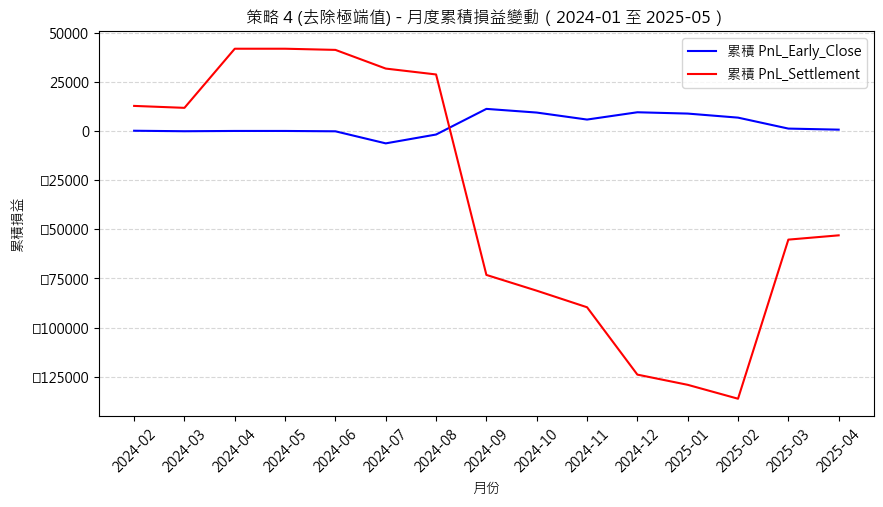

In [115]:
def plot_monthly_cumulative_pnl(df_early, df_settle, strategy_name, start_date=None, end_date=None):
    """分別繪製月度累積損益走勢，適用於不同的 Early Close 和 Settlement 數據"""

    # **確保 'NewDate' 為 datetime 格式**
    for df in [df_early, df_settle]:
        df["NewDate"] = pd.to_datetime(df["NewDate"], errors="coerce")
        df.dropna(subset=["NewDate"], inplace=True)
        assert df["NewDate"].dtype == "datetime64[ns]", "🚨 NewDate 欄位仍不是 datetime 格式！請檢查原始資料。"
        df["Month"] = df["NewDate"].dt.to_period("M")  # **轉換為月份**

    # **篩選時間範圍**
    if start_date and end_date:
        start_date, end_date = pd.to_datetime(start_date), pd.to_datetime(end_date)
        df_early = df_early[(df_early["NewDate"] >= start_date) & (df_early["NewDate"] <= end_date)]
        df_settle = df_settle[(df_settle["NewDate"] >= start_date) & (df_settle["NewDate"] <= end_date)]

    # **計算每月損益**
    df_monthly_early = df_early.groupby("Month", as_index=False)["PnL_Early_Close"].sum()
    df_monthly_settle = df_settle.groupby("Month", as_index=False)["PnL_Settlement"].sum()

    # **填補缺失月份**
    full_months = pd.period_range(start=df_monthly_early["Month"].min(), end=df_monthly_early["Month"].max(), freq="M")
    df_monthly_early = df_monthly_early.set_index("Month").reindex(full_months, fill_value=0).reset_index()
    df_monthly_settle = df_monthly_settle.set_index("Month").reindex(full_months, fill_value=0).reset_index()

    df_monthly_early.rename(columns={"index": "Month"}, inplace=True)
    df_monthly_settle.rename(columns={"index": "Month"}, inplace=True)

    # **計算累積損益**
    df_monthly_early["Cumulative_PnL_Early_Close"] = df_monthly_early["PnL_Early_Close"].cumsum()
    df_monthly_settle["Cumulative_PnL_Settlement"] = df_monthly_settle["PnL_Settlement"].cumsum()

    # **繪製累積損益折線圖**
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(df_monthly_early["Month"].astype(str), df_monthly_early["Cumulative_PnL_Early_Close"], color="blue", linestyle="-", label="累積 PnL_Early_Close")
    ax.plot(df_monthly_settle["Month"].astype(str), df_monthly_settle["Cumulative_PnL_Settlement"], color="red", linestyle="-", label="累積 PnL_Settlement")

    ax.set_title(f"{strategy_name} - 月度累積損益變動（{start_date.strftime('%Y-%m')} 至 {end_date.strftime('%Y-%m')}）" if start_date and end_date else f"{strategy_name} - 月度累積損益變動")
    ax.set_xlabel("月份")
    ax.set_ylabel("累積損益")
    ax.legend()
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    plt.xticks(rotation=45)
    plt.show()

# df_new_4
# df_clean
# df_fliter
# df_new_4_call, df_new_4_put
# df_clean_4_call, df_clean_4_put
# df_fliter_call, df_fliter_put

# **測試函數**
plot_monthly_cumulative_pnl(df_clean, df_clean, "策略 4 (去除極端值)", start_date="2024-01-01", end_date="2025-05-01")

#### 繪製Delta變化圖

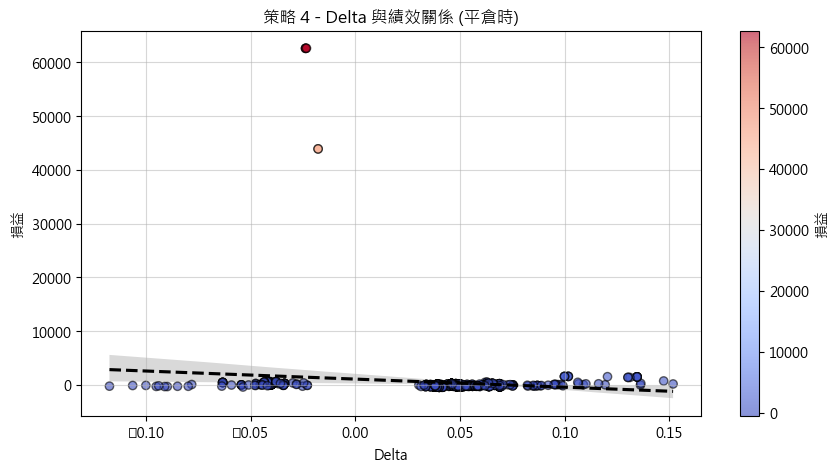

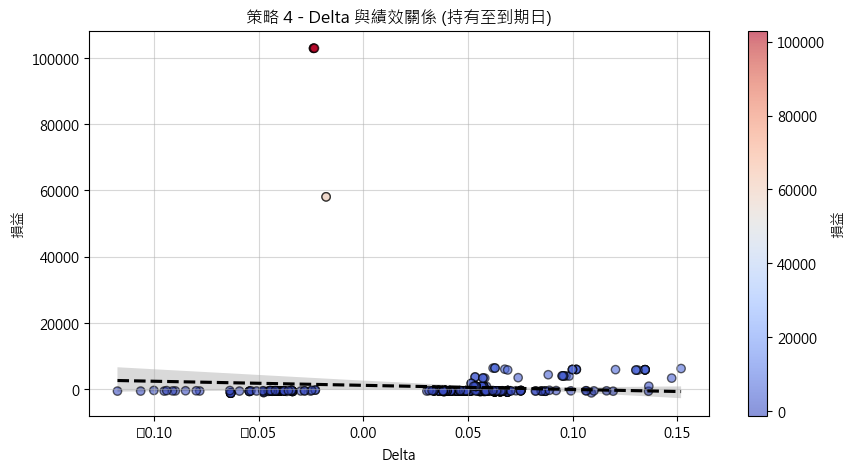

In [23]:
def plot_delta_vs_pnl(df, strategy_name, use_settlement=False):
    """繪製 Delta 與損益的關係（散點圖）"""

    df = df.copy()
    df["Delta"] = pd.to_numeric(df["Delta"], errors="coerce")  # **確保 Delta 為數值**
    
    # **選擇 PnL**
    pnl_col = "PnL_Settlement" if use_settlement else "PnL_Early_Close"
    df[pnl_col] = pd.to_numeric(df[pnl_col], errors="coerce")  # **確保 PnL 為數值**
    
    # **移除 NaN 值**
    df = df.dropna(subset=["Delta", pnl_col])
    
    # **繪製散點圖**
    plt.figure(figsize=(10, 5))
    scatter = plt.scatter(df["Delta"], df[pnl_col], c=df[pnl_col], cmap="coolwarm", alpha=0.6, edgecolors="black")

    # **加入顏色條**
    cbar = plt.colorbar(scatter)
    cbar.set_label("損益")

    # **趨勢線**
    sns.regplot(x=df["Delta"], y=df[pnl_col], scatter=False, line_kws={"color": "black", "linestyle": "--"})

    plt.title(f"{strategy_name} - Delta 與績效關係 ({'持有至到期日' if use_settlement else '平倉時'})")
    plt.xlabel("Delta")
    plt.ylabel("損益")
    plt.grid(alpha=0.5)
    plt.show()

plot_delta_vs_pnl(df_new_4, "策略 4", use_settlement=False)  # **使用平倉 PnL**
plot_delta_vs_pnl(df_new_4, "策略 4", use_settlement=True)  # **使用持有至到期日 PnL**

計算逐日Delta累積

隔日平倉策略：每天都是全新的一天

持有到到期日策略：累積到到期日前 (觀察累積之Delta大小)

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_16456\1200015281.py:75: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


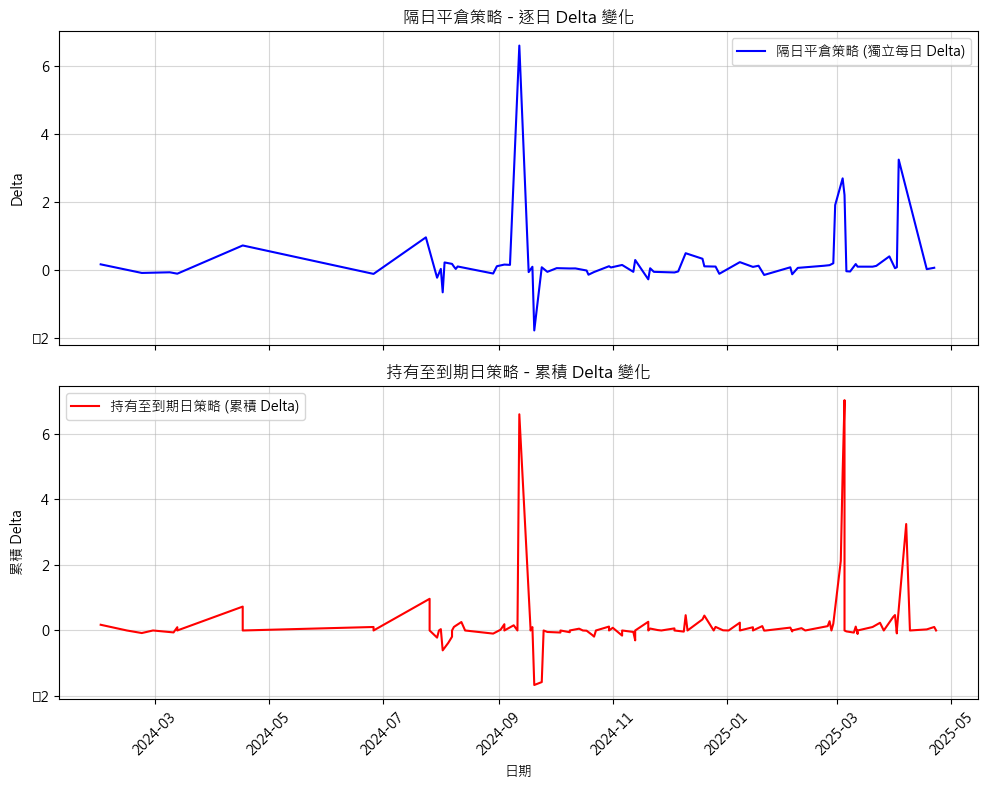

In [35]:
def prepare_delta_data(df):
    """準備 Delta 數據，確保其為數值型態"""
    
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])  # **確保 Date 為 datetime**
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **確保 SettlementDate 為 datetime**
    df["NewDate"] = pd.to_datetime(df["NewDate"])

    # **確保 Delta 是數值型態**
    df["Delta"] = pd.to_numeric(df["Delta"], errors="coerce")

    # **移除 NaN，避免影響計算**
    df = df.dropna(subset=["Date", "SettlementDate", "NewDate", "Delta"])

    return df

def calculate_daily_delta(df):
    """隔日平倉策略：每天的 Delta 不累積，僅計算當天值"""
    df_daily = df.groupby("Date", as_index=False)["Delta"].sum()
    df_daily.rename(columns={"Delta": "Daily_Delta"}, inplace=True)
    return df_daily

def calculate_cumulative_delta(df):
    """持有至到期日策略：每日 Delta 累積，並在 SettlementDate 到期時扣除相應數據"""
    
    # **確保數據格式**
    df = df.copy()
    df["NewDate"] = pd.to_datetime(df["NewDate"])  # **轉換 NewDate 為 datetime**
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])  # **轉換 SettlementDate 為 datetime**
    df["Delta"] = pd.to_numeric(df["Delta"], errors="coerce")  # **確保 Delta 為數值型態**
    
    # **移除 NaN，避免錯誤計算**
    df = df.dropna(subset=["NewDate", "SettlementDate", "Delta"])
    
    # **計算每日 Delta（累積）**
    df_daily = df.groupby("NewDate", as_index=False)["Delta"].sum()
    df_daily["Cumulative_Delta"] = df_daily["Delta"].cumsum()

    # **處理 SettlementDate 到期時的扣除**
    df_settlement = df.groupby("SettlementDate", as_index=False)["Delta"].sum()
    df_settlement["NewDate"] = df_settlement["SettlementDate"]  # **將到期日映射為要扣除的日期**
    df_settlement["Delta"] = -df_settlement["Delta"]  # **轉為負數（表示扣除）**

    # **合併每日累積數據 & 到期日扣除數據**
    df_combined = pd.concat([df_daily, df_settlement], ignore_index=True).sort_values("NewDate")
    df_combined["Cumulative_Delta_Adjusted"] = df_combined["Delta"].cumsum()
    df_combined["Cumulative_Delta"] = df_combined["Cumulative_Delta"].fillna(0)

    # **確保輸出日期欄位名稱一致**
    df_combined.rename(columns={"NewDate": "Date"}, inplace=True)

    return df_combined

def plot_delta_trends(df_daily, df_cumulative):
    """繪製 Delta 累積趨勢比較"""

    fig, ax = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # **隔日平倉策略**
    ax[0].plot(df_daily["Date"], df_daily["Daily_Delta"], color="blue", linestyle="-", label="隔日平倉策略 (獨立每日 Delta)")
    ax[0].set_title("隔日平倉策略 - 逐日 Delta 變化")
    ax[0].set_ylabel("Delta")
    ax[0].legend()
    ax[0].grid(alpha=0.5)

    # **持有至到期日策略**
    ax[1].plot(df_cumulative["Date"], df_cumulative["Cumulative_Delta_Adjusted"], color="red", linestyle="-", label="持有至到期日策略 (累積 Delta)")
    ax[1].set_title("持有至到期日策略 - 累積 Delta 變化")
    ax[1].set_xlabel("日期")
    ax[1].set_ylabel("累積 Delta")
    ax[1].legend()
    ax[1].grid(alpha=0.5)

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


df_clean_1 = prepare_delta_data(df_new_4)
df_daily_delta = calculate_daily_delta(df_clean_1)
df_cumulative_delta = calculate_cumulative_delta(df_clean_1)
plot_delta_trends(df_daily_delta, df_cumulative_delta)

In [25]:
date_counts = df_new_4["Date"].value_counts().reset_index()
date_counts.columns = ["Date", "Count"]
date_counts = date_counts.sort_values(by="Count", ascending=False)  # **由高到低排序**

# **顯示前 10 名**
print(date_counts.head(10))

         Date  Count
0  2024-09-12    136
1  2025-04-03     94
2  2024-12-19     49
3  2025-03-04     47
4  2024-09-20     44
5  2025-02-28     39
6  2025-03-05     18
7  2024-07-24     14
8  2024-08-02     14
9  2025-03-29      7


C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_16456\425016496.py:44: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


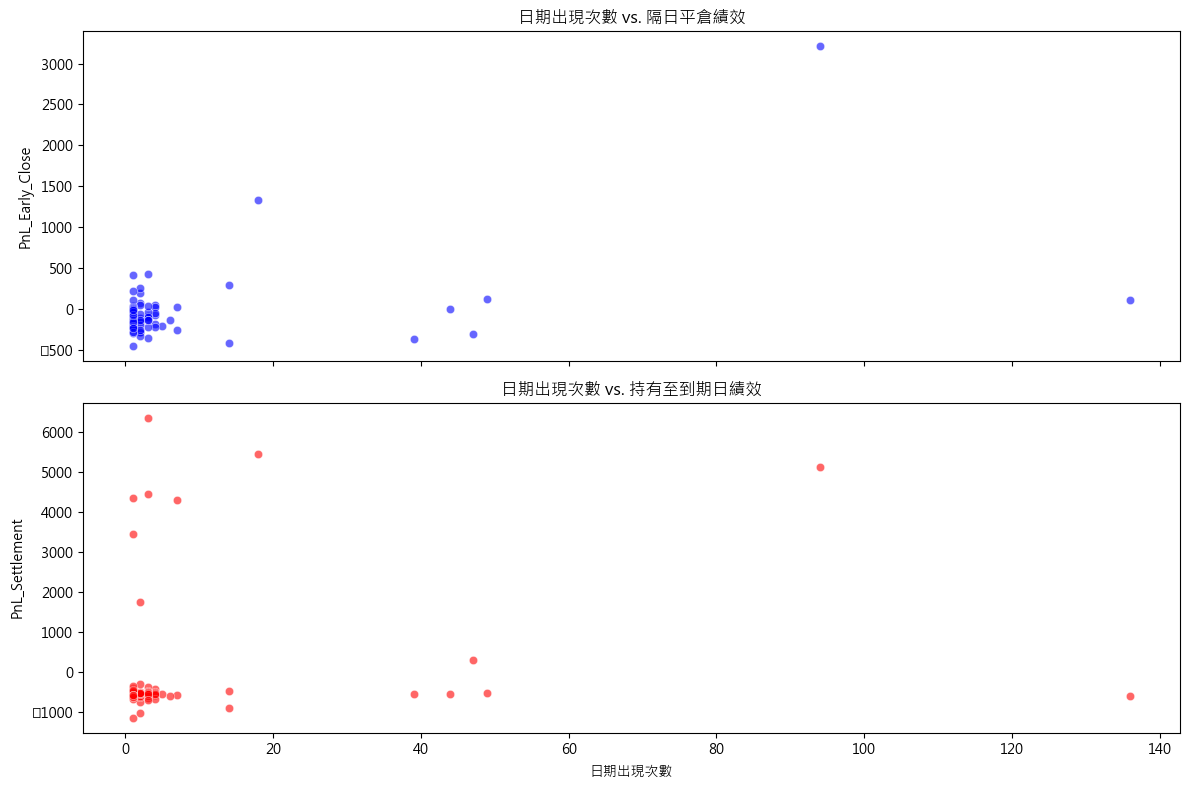

In [26]:
def analyze_date_performance(df):
    """分析日期出現次數與績效的關係"""
    
    df = df.copy()
    
    # **確保數據格式正確**
    df["Date"] = pd.to_datetime(df["Date"])  # 確保 Date 是 datetime
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])
    df["PnL_Early_Close"] = pd.to_numeric(df["PnL_Early_Close"], errors="coerce")
    df["PnL_Settlement"] = pd.to_numeric(df["PnL_Settlement"], errors="coerce")
    
    # **計算日期出現次數**
    date_counts = df["Date"].value_counts().reset_index()
    date_counts.columns = ["Date", "Count"]
    
    # **按日期計算平均績效**
    df_performance = df.groupby("Date").agg({
        "PnL_Early_Close": "mean",
        "PnL_Settlement": "mean"
    }).reset_index()
    
    # **合併日期頻率與績效數據**
    df_analysis = date_counts.merge(df_performance, on="Date", how="left")
    
    return df_analysis

def plot_date_vs_pnl(df_analysis):
    """視覺化日期頻率 vs. PnL 表現"""
    
    fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    
    # **散點圖：日期頻率 vs. 隔日平倉績效**
    sns.scatterplot(x=df_analysis["Count"], y=df_analysis["PnL_Early_Close"], ax=ax[0], color="blue", alpha=0.6)
    ax[0].set_title("日期出現次數 vs. 隔日平倉績效")
    ax[0].set_xlabel("日期出現次數")
    ax[0].set_ylabel("PnL_Early_Close")

    # **散點圖：日期頻率 vs. 持有至到期日績效**
    sns.scatterplot(x=df_analysis["Count"], y=df_analysis["PnL_Settlement"], ax=ax[1], color="red", alpha=0.6)
    ax[1].set_title("日期出現次數 vs. 持有至到期日績效")
    ax[1].set_xlabel("日期出現次數")
    ax[1].set_ylabel("PnL_Settlement")

    plt.tight_layout()
    plt.show()


df_analysis = analyze_date_performance(df_new_4)
plot_date_vs_pnl(df_analysis)

C:\Users\ptdintern1.fut\AppData\Local\Temp\ipykernel_16456\3841216682.py:67: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  plt.tight_layout()
c:\Users\ptdintern1.fut\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) Microsoft JhengHei.
  fig.canvas.print_figure(bytes_io, **kw)


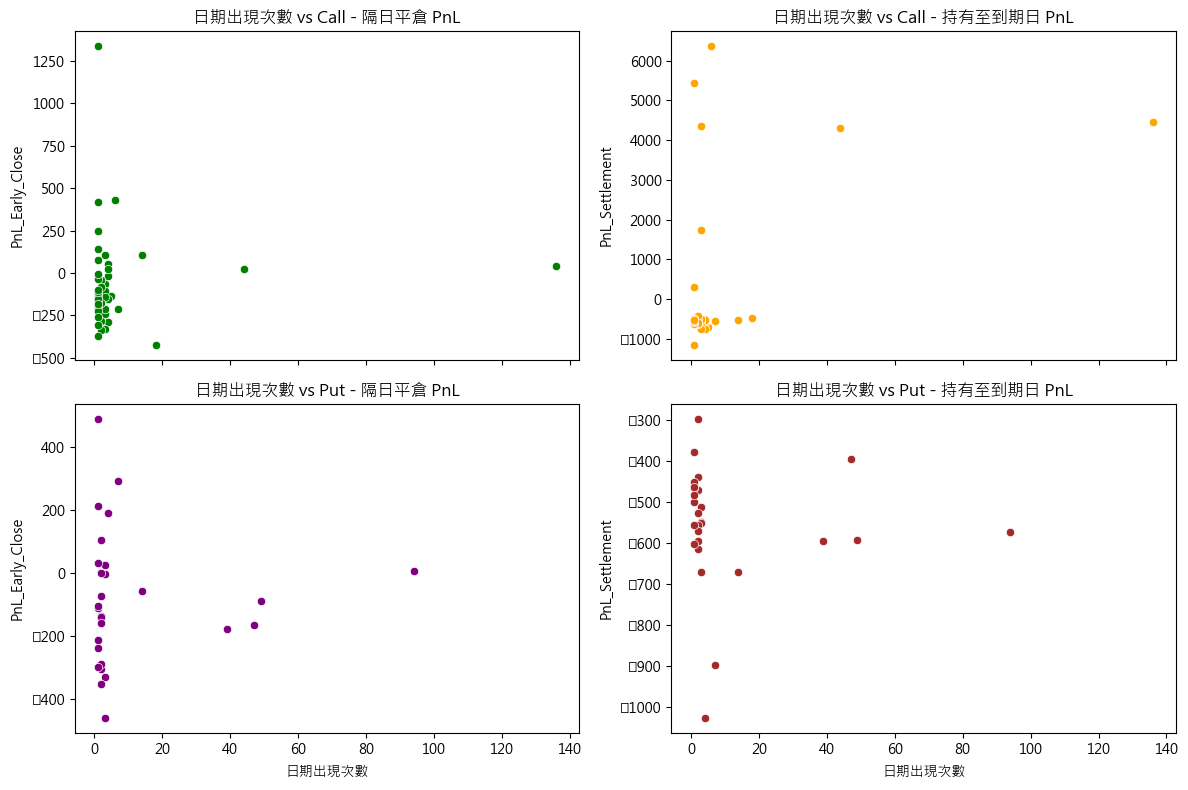

In [27]:
def analyze_option_date_performance(df):
    """分析日期出現次數與 Call/Put 交易及其績效關係"""
    
    df = df.copy()
    
    # **確保數據格式正確**
    df["Date"] = pd.to_datetime(df["Date"])  
    df["SettlementDate"] = pd.to_datetime(df["SettlementDate"])
    df["PnL_Early_Close"] = pd.to_numeric(df["PnL_Early_Close"], errors="coerce")
    df["PnL_Settlement"] = pd.to_numeric(df["PnL_Settlement"], errors="coerce")

    # **計算日期出現次數**
    date_counts = df["Date"].value_counts().reset_index()
    date_counts.columns = ["Date", "Count"]
    
    # **按日期計算 Call & Put 數量**
    df_call = df[df["Category"] == "C"]
    df_put = df[df["Category"] == "P"]

    call_counts = df_call["Date"].value_counts().reset_index()
    call_counts.columns = ["Date", "Call_Count"]
    
    put_counts = df_put["Date"].value_counts().reset_index()
    put_counts.columns = ["Date", "Put_Count"]

    # **按日期計算 PnL**
    df_pnl = df.groupby(["Date", "Category"]).agg({
        "PnL_Early_Close": "mean",
        "PnL_Settlement": "mean"
    }).reset_index()

    return date_counts, call_counts, put_counts, df_pnl

def plot_option_date_relationship(date_counts, df_pnl):
    """視覺化 日期出現次數 vs Call/Put PnL 表現"""

    fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

    # **日期出現次數 vs Call - 隔日平倉 PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "C"]["PnL_Early_Close"], ax=ax[0, 0], color="green")
    ax[0, 0].set_title("日期出現次數 vs Call - 隔日平倉 PnL")
    ax[0, 0].set_xlabel("日期出現次數")
    ax[0, 0].set_ylabel("PnL_Early_Close")

    # **日期出現次數 vs Call - 持有至到期日 PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "C"]["PnL_Settlement"], ax=ax[0, 1], color="orange")
    ax[0, 1].set_title("日期出現次數 vs Call - 持有至到期日 PnL")
    ax[0, 1].set_xlabel("日期出現次數")
    ax[0, 1].set_ylabel("PnL_Settlement")

    # **日期出現次數 vs Put - 隔日平倉 PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "P"]["PnL_Early_Close"], ax=ax[1, 0], color="purple")
    ax[1, 0].set_title("日期出現次數 vs Put - 隔日平倉 PnL")
    ax[1, 0].set_xlabel("日期出現次數")
    ax[1, 0].set_ylabel("PnL_Early_Close")

    # **日期出現次數 vs Put - 持有至到期日 PnL**
    sns.scatterplot(x=date_counts["Count"], 
                    y=df_pnl[df_pnl["Category"] == "P"]["PnL_Settlement"], ax=ax[1, 1], color="brown")
    ax[1, 1].set_title("日期出現次數 vs Put - 持有至到期日 PnL")
    ax[1, 1].set_xlabel("日期出現次數")
    ax[1, 1].set_ylabel("PnL_Settlement")

    plt.tight_layout()
    plt.show()



date_counts, call_counts, put_counts, df_pnl = analyze_option_date_performance(df_new_4)
plot_option_date_relationship(date_counts, df_pnl)